In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers,metrics,losses,optimizers,utils,backend as K

2024-02-20 18:00:24.264283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 18:00:24.264334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 18:00:24.265765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [90]:
dataP = r'/kaggle/input/celeba-dataset'

In [111]:
IM_SIZE = 128
DIM = 400
BETA = 2000

In [112]:
def getData(path):
    return utils.image_dataset_from_directory(
    path,
    labels=None,
    color_mode='rgb',
    batch_size=64,
    image_size=(IM_SIZE,IM_SIZE),
    shuffle=True,
    interpolation='bilinear')

trainT = getData(dataP)

Found 202599 files belonging to 1 classes.


In [113]:
def pre(i):
    i = tf.cast(i,"float32")/255
    return i
dataTr = trainT.map(lambda i: pre(i))

In [6]:
class sampl(layers.Layer):
    def call(self,ins):
        m,v = ins
        batch = tf.shape(m)[0]
        dim = tf.shape(m)[1]
        e = K.random_normal((batch,dim))
        return m+tf.exp(-.5*v)*e

In [114]:
e_in = layers.Input((IM_SIZE,IM_SIZE,3))
l = layers.Conv2D(64,(3,3),strides=2,padding="same")(e_in)
l = layers.BatchNormalization()(l)
l = layers.LeakyReLU()(l)
l = layers.Conv2D(64,(3,3),strides=2,padding="same")(l)
l = layers.BatchNormalization()(l)
l = layers.LeakyReLU()(l)
l = layers.Conv2D(64,(3,3),strides=2,padding="same")(l)
l = layers.BatchNormalization()(l)
l = layers.LeakyReLU()(l)
old_shape = K.int_shape(l)[1:]
l = layers.Flatten()(l)
m = layers.Dense(DIM)(l)
v = layers.Dense(DIM)(l)
z = sampl()([m,v])
encoder = models.Model(e_in,[m,v,z])
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)           0         ['batch_normalization[0][0

In [115]:
d_in = layers.Input((DIM,))
l = layers.Dense(np.prod(old_shape))(d_in)
l = layers.Reshape(old_shape)(l)
l = layers.Conv2DTranspose(64,(3,3),strides=2,padding="same")(l)
l = layers.BatchNormalization()(l)
l = layers.LeakyReLU()(l)
l = layers.Conv2DTranspose(64,(3,3),strides=2,padding="same")(l)
l = layers.BatchNormalization()(l)
l = layers.LeakyReLU()(l)
l = layers.Conv2DTranspose(64,(3,3),strides=2,padding="same")(l)
l = layers.BatchNormalization()(l)
l = layers.LeakyReLU()(l)
d_out = layers.Conv2D(3,(3,3),strides=1,activation="sigmoid",padding="same")(l)
decoder = models.Model(d_in,d_out)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400)]             0         
                                                                 
 dense_2 (Dense)             (None, 16384)             6569984   
                                                                 
 reshape (Reshape)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 64)        36928     
 anspose)                                                        
                                                                 
 batch_normalization_3 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0   

In [116]:
class VAE(models.Model):
    def __init__(self,en,de,**a):
        super(VAE,self).__init__(**a)
        self.en = en
        self.de = de
        self.total_loss_track = metrics.Mean(name='total_loss')
        self.kl_loss_track = metrics.Mean(name='kl_loss')
        self.reconstruction_loss_track = metrics.Mean(name='reconstruction_loss')
    
    @property
    def metrics(self):
        return [
            self.total_loss_track,
            self.reconstruction_loss_track,
            self.kl_loss_track,
        ]
    
    def call(self,ins):
        m,v,z = self.en(ins)
        re = self.de(z)
        return m,v,re
    
    def train_step(self,data):
        with tf.GradientTape() as tp:
            m,v,re = self(data)
            reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data,re))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-.5*(1+v-tf.square(m)-tf.exp(v)),axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        gradients = tp.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients,self.trainable_weights))
        
        self.total_loss_track.update_state(total_loss)
        self.kl_loss_track.update_state(kl_loss)
        self.reconstruction_loss_track.update_state(reconstruction_loss)
        
        return {'total':self.total_loss_track.result()
               ,'kl':self.kl_loss_track.result(),
               'reconstruction':self.reconstruction_loss_track.result()}
    
    def test_step(self,data):
        if(isinstance(data,tuple)):
            data = data[0]
        m,v,re = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data,re))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-.5*(1+v-tf.square(m)-tf.exp(v)),axis=1))
        total_loss = reconstruction_loss + kl_loss
        
        return{'total':total_loss
               ,'kl':kl_loss,
               'reconstruction':reconstruction_loss}
            

In [117]:
K.clear_session()
model = None
model = VAE(encoder,decoder)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005))

In [118]:
model.fit(dataTr,epochs=5)

Epoch 1/5
3166/3166 [==============================] - 460s 143ms/step - total: 1140.2567 - kl: 35.0697 - reconstruction: 1105.1881
Epoch 2/5
3166/3166 [==============================] - 449s 142ms/step - total: 1096.9334 - kl: 39.1641 - reconstruction: 1057.7699
Epoch 3/5
3166/3166 [==============================] - 449s 142ms/step - total: 1092.9052 - kl: 39.6981 - reconstruction: 1053.2067
Epoch 4/5
3166/3166 [==============================] - 449s 142ms/step - total: 1091.0550 - kl: 39.9087 - reconstruction: 1051.1462
Epoch 5/5
3166/3166 [==============================] - 449s 142ms/step - total: 1089.8656 - kl: 40.0388 - reconstruction: 1049.8269


In [119]:
sample = dataTr.take(1).get_single_element()

In [120]:
imgs = np.array(list(sample))

In [121]:
en = encoder.predict(imgs)

2/2 [==============================] - 0s 6ms/step


In [122]:
m,v,re = model.predict(imgs)

2/2 [==============================] - 1s 7ms/step


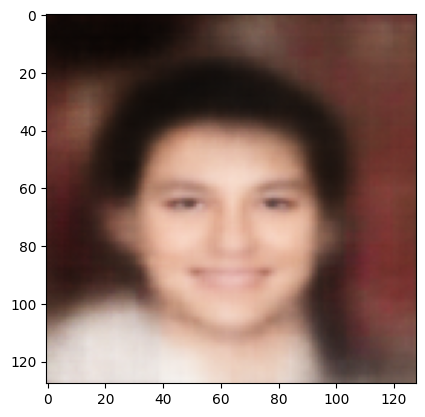

In [124]:
import random
i = round(random.random() * 64)
plt.imshow(re[i])

In [125]:
# mins,maxs = np.min(en,axis=0),np.max(en,axis=0)
smpl = np.random.normal(size=(15*15,DIM))
dd = decoder.predict(smpl)

8/8 [==============================] - 1s 56ms/step


In [ ]:
plt.imshow(dd[round(random.random()*224)])